# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
import seaborn as sns; sns.set()
from scipy.spatial.distance import cdist

/Users/Home/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Load feature names.

In [2]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)
#print 'Loaded feature names:', (feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        #print line
        
        items = line.split()
        #print items
        #break
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape
print test_data.shape

(7000, 126)
(1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].


**************************************************************************************************************

Fraction of the total variance in the training data, explained by the first 1 principal component(s): 0.16

Fraction of the total variance in the training data, explained by the first 50 principal component(s): 0.98

**************************************************************************************************************


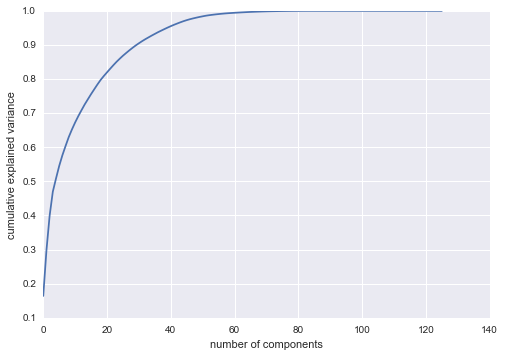

In [4]:
def P1(k):
### STUDENT START ###
    print('\n**************************************************************************************************************')
    for i in range(len(k)):
        pca = PCA(n_components=k[i])
        pca.fit(train_data)
        #print pca.components_.T[:, 0]
        #print 'explained_variance_', pca.explained_variance_
        # Get cumulative explained varioance ratio for for k in [1, 50]
        print('\nFraction of the total variance in the training data, explained by the first %d principal component(s): %3.2f' 
                  %(k[i], np.cumsum(pca.explained_variance_ratio_)[k[i]-1]))
# To get Fraction of the total variance in the training data, explained by the each principal component uncomment following lines
    #print('\n**************************************************************************************************************')
    #for j in range(len(pca.explained_variance_ratio_)): 
        #print('\nFraction of the total variance in the training data, explained by the %d principal component: %3.3f' 
                  #%(j+1, pca.explained_variance_ratio_[j]))
                
    print('\n**************************************************************************************************************')
    pca_2 = PCA().fit(train_data)
    # Plot cumulative explained variance ratio as a function of the number of components.
    plt.plot(np.cumsum(pca_2.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
### STUDENT END ###
k= [1, 50]
P1(k)

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Original train data shape:  (7000, 126)
Train data shape after PCA:  (7000, 2)


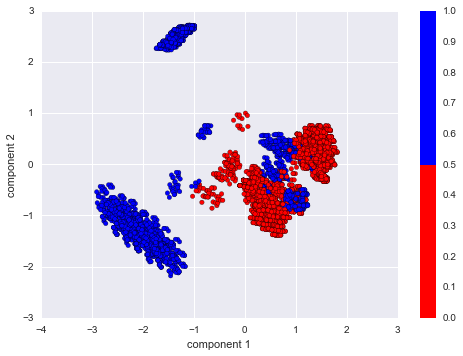

In [5]:
# Method to convert the data into 2d (or based on the passed number of componenets) Data using PCA
def PCA2dData(n_components=2, data=train_data):
    pca = PCA(n_components)
    projected_train_data = pca.fit_transform(train_data)
    return projected_train_data
def P2():
### STUDENT START ###
    projected_train_data = PCA2dData(n_components=2, data=train_data)
    print 'Original train data shape: ', (train_data.shape)
    print 'Train data shape after PCA: ',(projected_train_data.shape)
    colors = ['red','blue']
    # Scatter plot with positive (poisonous) cases in blue and the negative (non-poisonous) in red.
    plt.scatter(projected_train_data[:, 0], projected_train_data[:, 1], c=train_labels, cmap=matplotlib.colors.ListedColormap(colors) )
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar();
    

### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

In [6]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    #Get the predicted KMeans cluster labels
    labels = kmeans.fit_predict(X)
    #Plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='rainbow', zorder=2)
    # Get centers for KMeans clusters
    centers = kmeans.cluster_centers_
    # Get the radius of cluster by estimating distance from the center to the most distant point.
    radii = [cdist(X[labels == i], [center]).max()
                for i, center in enumerate(centers)]
    # Mark each centroid cluster and plot a circle using the radius above
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100);
    plt.title('KMeans with number of clusters: %d' %len(centers))
    plt.show();

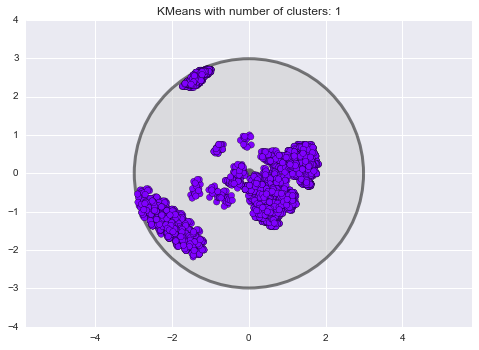

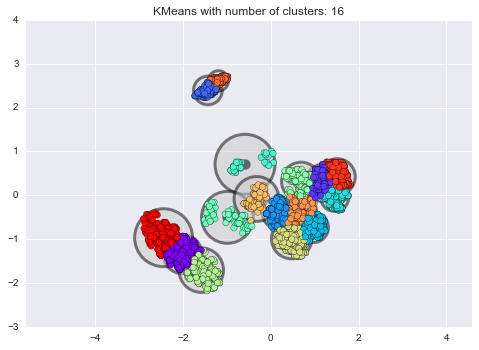

In [7]:
def P3():
### STUDENT START ###
    # Get the 2d projected data
    projected_train_data = PCA2dData(n_components=2, data=train_data)
    k = [1, 16] 
    # Run KMeans with [1,16] clusters over the 2d projected data.
    for i in range(len(k)):
        kmeans = KMeans(n_clusters=k[i], random_state=0)
        plot_kmeans(kmeans, projected_train_data)
### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

X_train positive examples shape:  (3198, 2)


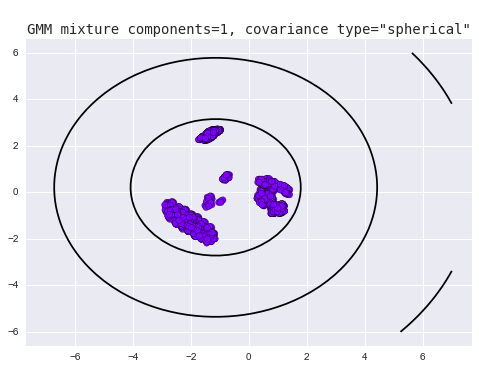

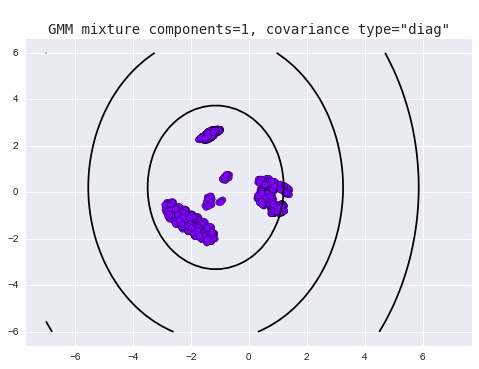

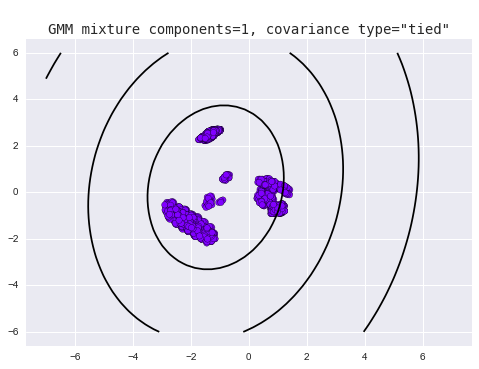

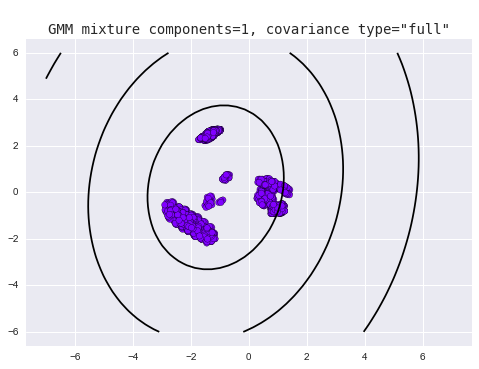

/Users/Home/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


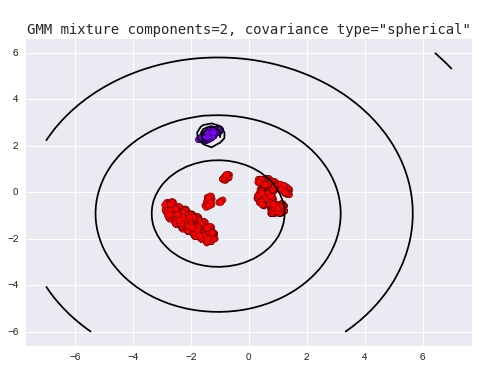

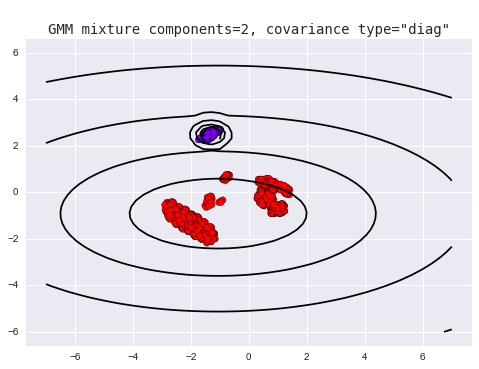

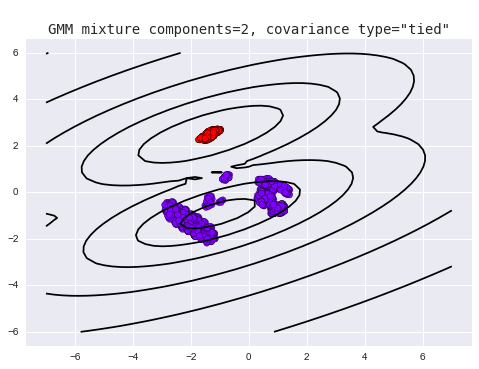

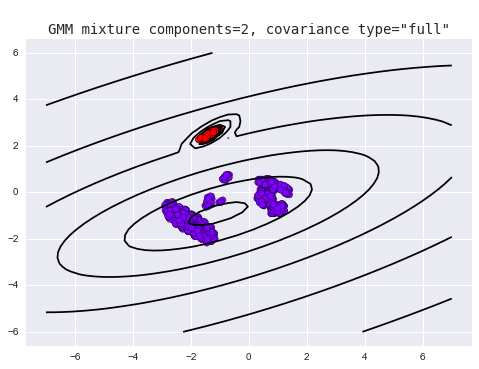

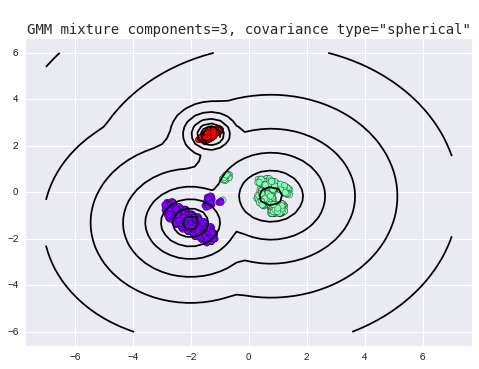

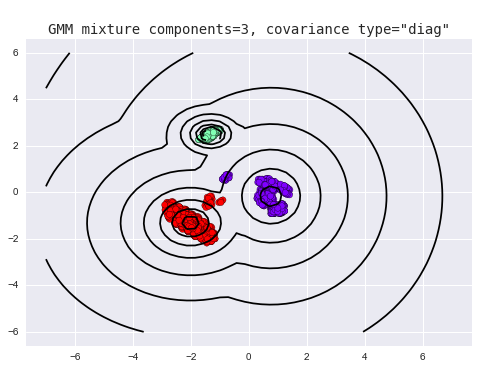

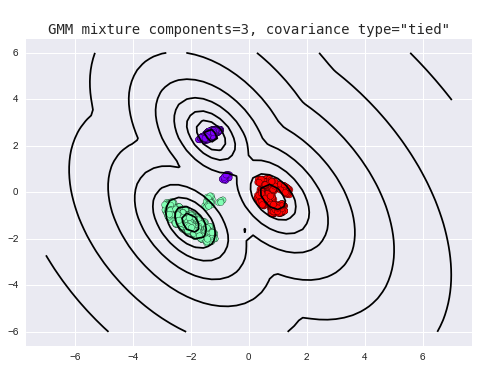

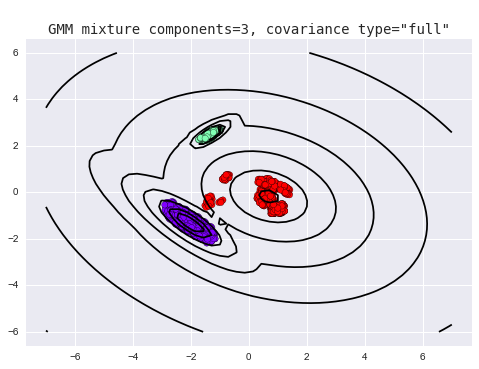

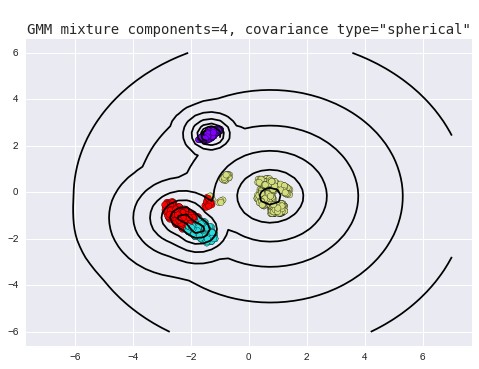

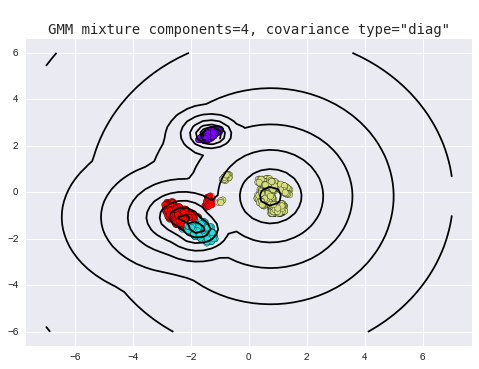

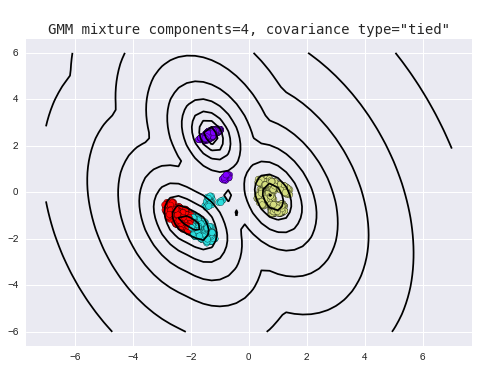

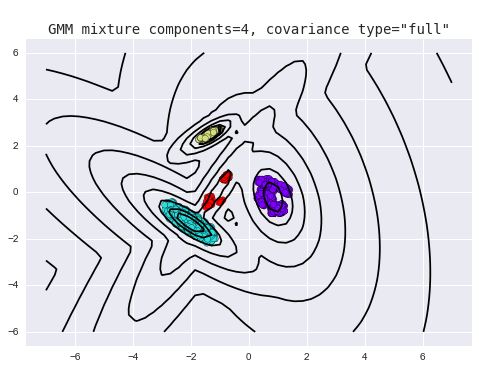

In [8]:
def P4():
### STUDENT START ###
    #Get the positive examples in the 2d projected data
    X_train = PCA2dData(n_components=2, data=train_data)
    X_train_positive = X_train[train_labels==1]
    print 'X_train positive examples shape: ', X_train_positive.shape
    mixture_components = [1, 2, 3, 4]
    covariance_type = ['spherical', 'diag', 'tied', 'full']

    for i in range(len(mixture_components)):
        for j in range(len(covariance_type)):
            # Fit a Gaussian Mixture Model for the positive examples in the 2d projected data
            clf = GMM(n_components=mixture_components[i], covariance_type=covariance_type[j]).fit(X_train_positive)
            labels = clf.predict(X_train_positive)
            plt.scatter(X_train_positive[:, 0], X_train_positive[:, 1], c=labels, s=40, cmap='rainbow')
            x = np.linspace(-7., 7.)
            y = np.linspace(-6., 6.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z,_  = clf.score_samples(XX)
            Z = (-Z).reshape(X.shape)
            ## display predicted scores by the model as a contour plot
            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10), colors='black' )
            plt.title('\nGMM mixture components={0}, covariance type="{1}"'.format(mixture_components[i], covariance_type[j]),size=14, family='monospace')
            plt.axis('tight')
            plt.show()
### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [9]:
def P5():
### STUDENT START ###
    n_components=2
    # Get tge 2d projected data using PCA
    pca = PCA(n_components=n_components).fit(train_data)
    train_data_pca = pca.transform(train_data)
    test_data_pca = pca.transform(test_data)
    # Get the positive and genative train examples
    positive_train_examples = train_data_pca[train_labels==1]
    negative_train_examples = train_data_pca[train_labels==0]
    # Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in the 2d projected data.
    gmm_positive = GMM(n_components=4, covariance_type='full').fit(positive_train_examples)
    gmm_negative = GMM(n_components=4, covariance_type='full').fit(negative_train_examples)

    # Predict the test examples by choosing the label for which the model gives a larger probability.
    positive = gmm_positive.score(test_data_pca)
    negative = gmm_negative.score(test_data_pca)
    
    score = (positive > negative).astype(int)

    print 'Accuracy score: %2.3f%%' %(sum(score == test_labels) *100.0 / (len(test_labels)))
### STUDENT END ###

P5()

Accuracy score: 95.107%


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

### To estimate number of parameters for PCA components, GMM components, and different covariance types:

http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
<br>'spherical' (each component has its own single variance)
<br>'diag' (each component has its own diagonal covariance matrix)
<br>'tied' (all components share the same general covariance matrix)
<br>'full' (each component has its own general covariance matrix)

n_pca = number of PCA components <br>
n_gmm = number of GMM components<br>
n_classes =  number of classes (2)<br>

Formulas to estimate number of parameters for different covariance types:
1. Spherical<br>
number of paramters = [n_pca (mean vector) + 1 (covariance)] x n_gmm components  x 2 classes

2. Diag<br>
number of paramters = [n_pca (mean vector) + n_pca (covariance matrix)] x n_gmm components  x 2 classes

3. Tied<br>
First get the general covariance matrix: based on the formula  n_gcv = [n_pca  + ( n_pca * (n_pca-1)/2)<br>
number of paramters = [(n_pca (mean vector) x n_gmm components) + n_gcv (covariance matrix)]   x 2 classes

4. Full<br>
Get the general covariance matrix: based on the formula  n_gcv = [n_pca  + ( n_pca * (n_pca-1)/2)<br>
number of paramters = [n_pca (mean vector) + n_gcv (covariance matrix)] x n_gmm components  x 2 classes

In [10]:
def P6(num_top_models=10, pca_components_range=10, gmm_components_range=10):
### STUDENT START ###
    n_classes = 2
    covariance_type = ['spherical', 'diag', 'tied', 'full']
    data=[]
    n_prm=0
    for i in range(pca_components_range):
        for j in range(gmm_components_range):
            for k in range(len(covariance_type)):
                n_pca = i+1
                n_gmm = j+1
                full =  n_pca + (  n_pca * (n_pca - 1)/2  )
                # Applying formula for different covairance types as mentioned above to estimate number of parameters
                if (covariance_type[k] == 'spherical'):
                    n_prm =  ( n_pca  + 1) * n_gmm * n_classes
                elif (covariance_type[k] == 'diag'):
                    n_prm =  ( n_pca  + n_pca) * n_gmm * n_classes
                elif (covariance_type[k] == 'tied'):
                    n_prm = ( ( n_pca * n_gmm ) + full ) *  n_classes   
                elif (covariance_type[k] == 'full'):                  
                    n_prm = ( n_pca + full ) *  ( n_gmm * n_classes)
                # If number fo parameters is no more than 50 then fit two full covariance GMMs, one for the positive 
                # examples and one for the negative examples in the 2d projected data and calculate accuracy score
                if n_prm <=50:                        
                        pca = PCA(n_components=n_pca).fit(train_data)
                        train_data_pca = pca.transform(train_data)
                        test_data_pca = pca.transform(test_data)

                        positive_train_examples = train_data_pca[train_labels==1]
                        negative_train_examples = train_data_pca[train_labels==0]

                        gmm_positive = GMM(n_components=n_gmm, covariance_type=covariance_type[k]).fit(positive_train_examples)
                        gmm_negative = GMM(n_components=n_gmm, covariance_type=covariance_type[k]).fit(negative_train_examples)

                        positive = gmm_positive.score(test_data_pca)
                        negative = gmm_negative.score(test_data_pca)

                        score = (positive > negative).astype(int)
                        accuracy = sum(score == test_labels) *100.0 / (len(test_labels))

                        data.append({'n_pca': n_pca, 'n_gmm': n_gmm, 'covariance_type':covariance_type[k], 'n_prm':n_prm, 'accuracy': accuracy})

    # Sort the list based on the accuracy score
    newlist = sorted(data, key=lambda k: k['accuracy'], reverse=True) 
    
    print "{:<10} {:<10} {:<10} {:<20} {:<15} {:<10}".format('Rank','n_pca','n_gmm', 'covariance_type', 'n_parameters', 'accuracy_score')
    if(num_top_models< len(newlist)):
        for i in range(num_top_models):
                print "{:<10} {:<10} {:<10} {:<20} {:<15} {:<10}".format(i+1, newlist[i]['n_pca'], newlist[i]['n_gmm'], newlist[i]['covariance_type'], newlist[i]['n_prm'], 
                    round(newlist[i]['accuracy'], 4))
### STUDENT END ###

P6(num_top_models=20, pca_components_range=20, gmm_components_range=20)

Rank       n_pca      n_gmm      covariance_type      n_parameters    accuracy_score
1          7          3          spherical            48              97.331    
2          4          3          tied                 44              96.7972   
3          5          4          spherical            48              96.7972   
4          6          3          spherical            42              96.7972   
5          5          3          spherical            36              96.6192   
6          3          3          tied                 30              96.3523   
7          3          6          spherical            48              95.9964   
8          5          2          tied                 50              95.9964   
9          3          4          spherical            32              95.9075   
10         4          4          spherical            40              95.8185   
11         3          5          spherical            40              95.5516   
12         4          5 